In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from pathlib import Path

# === Define transitions and delays ===
transitions = {
    "CompromiseDevice": 2,
    "MitigateDevice": 3,
    "AdaptAttack": 1,
    "GainControl": 1,
    "HumanRecovery": 4,
    "RaiseAlert": 2,
    "TriggerMitigation": 2,
    "OverloadOperator": 3
}
transition_probs = {t: 0.6 for t in transitions}

# === Initial marking for each place ===
def initialize_places():
    return {
        "Devices": [("ECG", "ICU", "NORMAL")],
        "Attackers": [("STATIC", "ECG")],
        "SecuritySystem": ["ICU"],
        "Operators": [("ICU", "AVAILABLE")],
        "Alerts": []
    }

# === One simulation run ===
def simulate_one_run(steps=100, sim_id=0):
    places = initialize_places()
    token_ages = defaultdict(dict)
    latency_records = []
    throughput = defaultdict(int)
    place_token_history = defaultdict(list)

    for step in range(steps):
        # Track token birth time
        for place, tokens in places.items():
            for tok in tokens:
                if tok not in token_ages[place]:
                    token_ages[place][tok] = step

        # Record current token count
        for pname, tokens in places.items():
            place_token_history[pname].append(len(tokens))

        # Simulate transition firings
        for tname, delay in transitions.items():
            if random.random() > transition_probs[tname]:
                continue

            if tname == "CompromiseDevice":
                for att in places["Attackers"]:
                    for dev in list(places["Devices"]):
                        if dev[0] == att[1] and dev[2] == "NORMAL":
                            if step - token_ages["Devices"][dev] >= delay:
                                places["Devices"].remove(dev)
                                new_tok = (dev[0], dev[1], "COMPROMISED")
                                places["Devices"].append(new_tok)
                                token_ages["Devices"][new_tok] = step
                                throughput[tname] += 1
                                break

            elif tname == "MitigateDevice":
                for ss in places["SecuritySystem"]:
                    for dev in list(places["Devices"]):
                        if dev[2] == "COMPROMISED" and dev[1] == ss:
                            if step - token_ages["Devices"][dev] >= delay:
                                places["Devices"].remove(dev)
                                new_tok = (dev[0], dev[1], "DEGRADED")
                                places["Devices"].append(new_tok)
                                token_ages["Devices"][new_tok] = step
                                throughput[tname] += 1
                                break

            elif tname == "AdaptAttack":
                for a in list(places["Attackers"]):
                    if step - token_ages["Attackers"][a] >= delay:
                        places["Attackers"].remove(a)
                        new_tok = ("ADAPTIVE", a[1])
                        places["Attackers"].append(new_tok)
                        token_ages["Attackers"][new_tok] = step
                        throughput[tname] += 1
                        break

            elif tname == "GainControl":
                for a in list(places["Attackers"]):
                    if step - token_ages["Attackers"][a] >= delay:
                        places["Attackers"].remove(a)
                        new_tok = ("STEALTH", a[1])
                        places["Attackers"].append(new_tok)
                        token_ages["Attackers"][new_tok] = step
                        throughput[tname] += 1
                        break

            elif tname == "HumanRecovery":
                for op in places["Operators"]:
                    for dev in list(places["Devices"]):
                        if dev[2] == "QUARANTINED" and dev[1] == op[0] and op[1] == "AVAILABLE":
                            if step - token_ages["Devices"][dev] >= delay:
                                places["Devices"].remove(dev)
                                new_tok = (dev[0], dev[1], "NORMAL")
                                places["Devices"].append(new_tok)
                                token_ages["Devices"][new_tok] = step
                                throughput[tname] += 1
                                break

            elif tname == "RaiseAlert":
                for dev in places["Devices"]:
                    if step - token_ages["Devices"][dev] >= delay:
                        alert_tok = (dev[1], step)  # Unique token: (dept, timestamp)
                        places["Alerts"].append(alert_tok)
                        token_ages["Alerts"][alert_tok] = step
                        throughput[tname] += 1
                        break

            elif tname == "TriggerMitigation":
                for a in list(places["Alerts"]):
                    if step - token_ages["Alerts"][a] >= delay:
                        places["Alerts"].remove(a)
                        dept = a[0]
                        places["SecuritySystem"].append(dept)
                        token_ages["SecuritySystem"][dept] = step
                        latency_records.append(step - token_ages["Alerts"][a])  # Correct latency
                        throughput[tname] += 1
                        break

            elif tname == "OverloadOperator":
                for op in list(places["Operators"]):
                    if op[1] == "AVAILABLE" and step - token_ages["Operators"][op] >= delay:
                        places["Operators"].remove(op)
                        new_tok = (op[0], "OVERLOADED")
                        places["Operators"].append(new_tok)
                        token_ages["Operators"][new_tok] = step
                        throughput[tname] += 1
                        break

    return latency_records, throughput, place_token_history

# === Run multiple simulations ===
def run_all_simulations(nsim=100, steps=100):
    all_latencies = []
    all_throughputs = defaultdict(int)
    token_accumulator = defaultdict(list)

    for sim in range(nsim):
        latencies, throughput, history = simulate_one_run(steps=steps, sim_id=sim)
        all_latencies.extend(latencies)
        for k, v in throughput.items():
            all_throughputs[k] += v
        for place, values in history.items():
            token_accumulator[place].extend(values)

    return all_latencies, all_throughputs, token_accumulator

# === Run simulation and collect data ===
latency_records, transition_throughput, place_token_history = run_all_simulations()

# === Create plots directory ===
Path("plots").mkdir(exist_ok=True)

# === Plot 1: Latency histogram ===
latency_array = np.array(latency_records).astype(int)
bins = np.arange(latency_array.min(), latency_array.max() + 1)

plt.figure(figsize=(12, 6))
plt.hist(latency_array, bins=bins, color="darkgreen", edgecolor="black", alpha=0.8)
plt.title("Latency Distribution from Alert to Mitigation")
plt.xlabel("Latency (Steps)")
plt.ylabel("Frequency")
plt.xticks(bins, rotation=45)
plt.tight_layout()
plt.savefig("plots/latency_hist.png", dpi=300)
plt.close()

# === Plot 2: Mean token count per place ===
avg_tokens = {p: np.mean(ts) for p, ts in place_token_history.items()}
plt.figure(figsize=(12, 6))
plt.bar(avg_tokens.keys(), avg_tokens.values(), color="steelblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average Token Count")
plt.title("Mean Number of Tokens per Place (100 Simulations)")
plt.tight_layout()
plt.savefig("plots/mean_tokens.png", dpi=300)
plt.close()

# === Plot 3: Transition throughput ===
throughput_sorted = dict(sorted(transition_throughput.items(), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(12, 6))
plt.bar(throughput_sorted.keys(), throughput_sorted.values(), color="darkorange")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Total Firings")
plt.title("Transition Throughput Over 100 Simulations")
plt.tight_layout()
plt.savefig("plots/throughput.png", dpi=300)
plt.close()


In [3]:
print(f"Max latency observed: {max(latency_records)}")
print(f"Alerts mitigated after step 90: {[lat for lat in latency_records if lat > 90]}")


Max latency observed: 30
Alerts mitigated after step 90: []


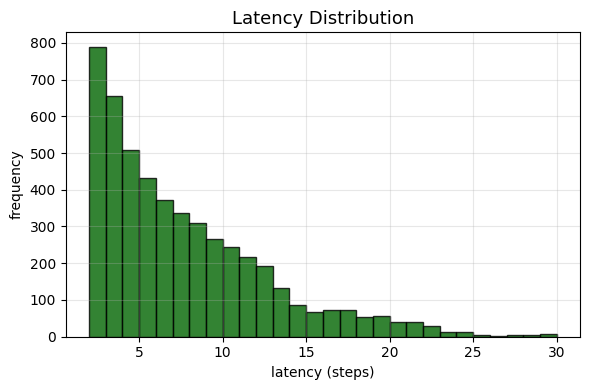

In [4]:
plt.figure(figsize=(6, 4))
latency_array = np.array(latency_records).astype(int)
bins = np.arange(latency_array.min(), latency_array.max() + 1)

plt.hist(latency_array, bins=bins, color="darkgreen", edgecolor="black", alpha=0.8)
plt.title("Latency Distribution", fontsize=13)
plt.xlabel("latency (steps)")
plt.ylabel("frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("./plots/latency_hist.pdf", bbox_inches='tight')
plt.show()


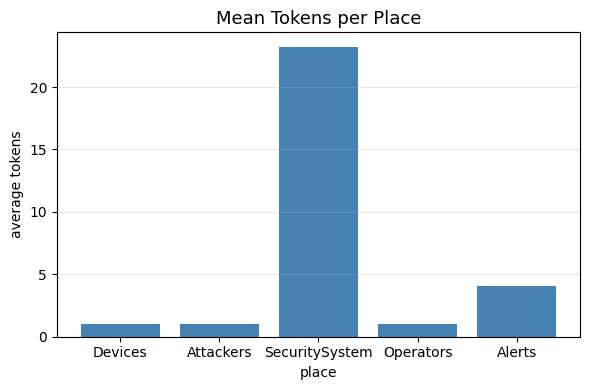

In [5]:
plt.figure(figsize=(6, 4))
avg_tokens = {p: np.mean(ts) for p, ts in place_token_history.items()}
plt.bar(avg_tokens.keys(), avg_tokens.values(), color="steelblue")
plt.title("Mean Tokens per Place", fontsize=13)
plt.xlabel("place")
plt.ylabel("average tokens")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("./plots/mean_tokens.pdf", bbox_inches='tight')
plt.show()


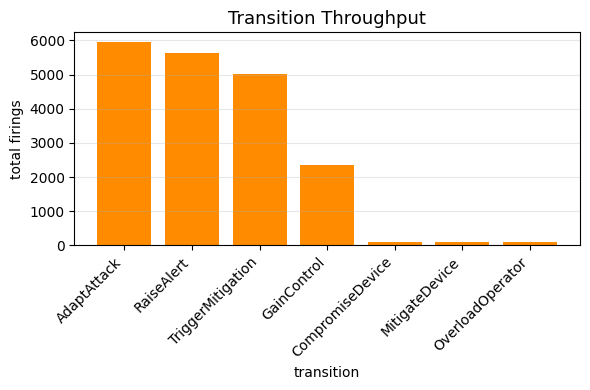

In [6]:
plt.figure(figsize=(6, 4))
throughput_sorted = dict(sorted(transition_throughput.items(), key=lambda x: x[1], reverse=True))
plt.bar(throughput_sorted.keys(), throughput_sorted.values(), color="darkorange")
plt.title("Transition Throughput", fontsize=13)
plt.xlabel("transition")
plt.ylabel("total firings")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("./plots/throughput.pdf", bbox_inches='tight')
plt.show()


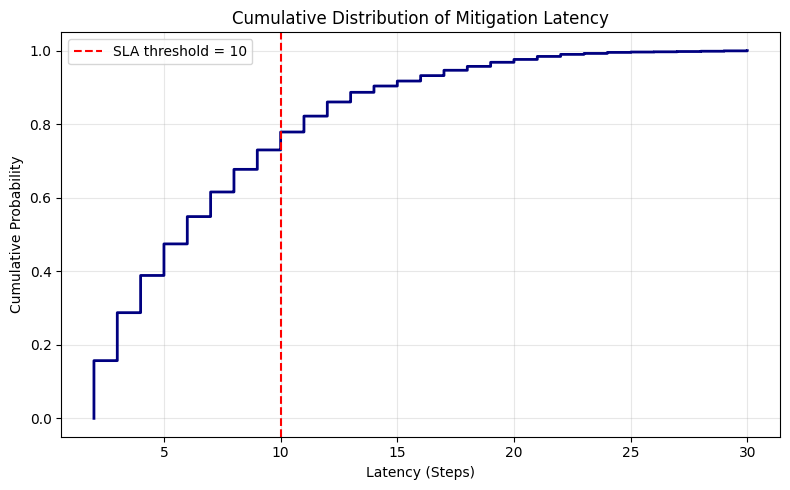

In [9]:
# === Plot 4: Latency CDF ===
sorted_latency = np.sort(latency_array)
cdf = np.arange(1, len(sorted_latency) + 1) / len(sorted_latency)

plt.figure(figsize=(8, 5))
plt.plot(sorted_latency, cdf, drawstyle='steps-post', lw=2, color='navy')
plt.axvline(x=10, color='red', linestyle='--', label='SLA threshold = 10')
plt.title("Cumulative Distribution of Mitigation Latency")
plt.xlabel("Latency (Steps)")
plt.ylabel("Cumulative Probability")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("plots/latency_cdf.pdf",  bbox_inches='tight')
